## Regression analysis of seagrass locations

**Aim**: to create a predictive model of carbon for seagrass beds using regression ML methods

### Firstly working just with acolite and gee derived data (ECU data not included yet)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from functools import reduce

## Import Data

In [3]:
## Import carbon data
path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1E_Final dataset\Outputs\final_dataset.csv"
df = pd.read_csv(path, index_col = 0)

## Import predictor variable data

In [60]:
#import acolite data
ac_max_path = 'C:/Users/nw431/OneDrive - University of Exeter/1_PhD Research/Project1_Carbon Model/Seagrass env variables/5_Neodaas Acolite/Outputs/final_outputs/acolite_max_df.csv'
ac_mean_path = 'C:/Users/nw431/OneDrive - University of Exeter/1_PhD Research/Project1_Carbon Model/Seagrass env variables/5_Neodaas Acolite/Outputs/final_outputs/acolite_mean_df.csv'
ac_min_path = 'C:/Users/nw431/OneDrive - University of Exeter/1_PhD Research/Project1_Carbon Model/Seagrass env variables/5_Neodaas Acolite/Outputs/final_outputs/acolite_min_df.csv'
ac_sum_path = 'C:/Users/nw431/OneDrive - University of Exeter/1_PhD Research/Project1_Carbon Model/Seagrass env variables/5_Neodaas Acolite/Outputs/final_outputs/acolite_sum_df.csv'

#import rainfall, pressure and temp data
pres_path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1_Environmental_variables\notebooks\outputs\pres_metrics.csv"
temp_path = 'C:/Users/nw431/OneDrive - University of Exeter/1_PhD Research/Project1_Carbon Model/Seagrass env variables/1_Environmental_variables/notebooks/outputs/temp_metrics.csv'
rain_path = 'C:/Users/nw431/OneDrive - University of Exeter/1_PhD Research/Project1_Carbon Model/Seagrass env variables/1_Environmental_variables/notebooks/outputs/rain_metrics.csv'

In [61]:
ac_max = pd.read_csv(ac_max_path, index_col = 0)
ac_mean = pd.read_csv(ac_mean_path, index_col = 0)
ac_min = pd.read_csv(ac_min_path, index_col = 0)
ac_sum = pd.read_csv(ac_sum_path, index_col = 0)
pres_df = pd.read_csv(pres_path, index_col = 0)
temp_df = pd.read_csv(temp_path, index_col = 0)
rain_df = pd.read_csv(rain_path, index_col = 0)

In [62]:
#import wave exposure data +eco region data
wav_path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1_Environmental_variables\data\final_variables\geo_exposures_by_ecoregion_rr.csv"
wave_df = pd.read_csv(wav_path, index_col = 1, usecols = ['Dataset_ID', 'exposure', 'ECO_CODE', 'ECOREGION', 'Lat_Zone', 'extr_exposure'])

In [63]:
#import distance to shore
dts_path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1_Environmental_variables\data\final_variables\distance_to_shore.csv"
dts = pd.read_csv(dts_path, index_col=0, usecols = ['Dataset_ID', 'NEAR_DIST'])
#dts

In [64]:
#import tidal range
tide_path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1_Environmental_variables\data\final_variables\tidal_range.csv"
tidal = pd.read_csv(tide_path, index_col = 0, usecols = ['Dataset_ID', 'Tidal_range'])

In [65]:
tidal

,Tidal_range
Dataset_ID,
ID_101,4.982402
ID_102,4.982402
ID_103,4.978427
ID_104,4.978427
ID_105,4.978427
...,...
ID_321,0.143439
ID_322,4.807916
ID_323,4.807916


### Join all the dfs together

In [66]:
#list of all dataframes to merge
dataframes = [sg_carbon_short, wave_df, dts, ac_max, ac_mean, ac_min, ac_sum, pres_df, temp_df, rain_df, tidal]

In [67]:
#join them all to wave df
df_all = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'outer'), dataframes)
df_all.head()

,Site_name,Lat,Long,Cstock25_Mgha,Species,Mono_mix,exposure,ECO_CODE,ECOREGION,Lat_Zone,...,sum_area_p3qaa_eta,sum_point_p3qaa_KPAR,sum_area_p3qaa_KPAR,mean_pressure,var_mean_pressure,mean_temp,var_mean_temp,mean_rain,var_mean_rain,Tidal_range
ID_101,Skagit Bay,48.315253,-122.477643,25.00,Z.marina,Monospecific,16975.58,25056.0,Puget Trough/Georgia Basin,Temperate,...,7.052567,7.728981,7.556927,101647.828125,5962.295061,283.723116,21.475274,0.117154,0.003776,4.982402
ID_102,Skagit Bay,48.315253,-122.477643,13.39,Bare,Bare,16975.58,25056.0,Puget Trough/Georgia Basin,Temperate,...,7.052567,7.728981,7.556927,101647.828125,5962.295061,283.723116,21.475274,0.117154,0.003776,4.982402
ID_103,Padilla Bay,48.546686,-122.531504,30.55,Bare,Bare,16945.96,25056.0,Puget Trough/Georgia Basin,Temperate,...,6.524136,7.490753,7.322623,101628.740755,5850.131964,283.408195,15.708502,0.126606,0.004936,4.978427
ID_104,Padilla Bay,48.546686,-122.531504,11.80,Z.marina,Monospecific,16945.96,25056.0,Puget Trough/Georgia Basin,Temperate,...,6.524136,7.490753,7.322623,101628.740755,5850.131964,283.408195,15.708502,0.126606,0.004936,4.978427
ID_105,Padilla Bay,48.504000,-122.519000,14.35,Z.marina,Monospecific,12801.49,25056.0,Puget Trough/Georgia Basin,Temperate,...,6.828719,7.010055,6.733094,101628.740755,5850.131964,283.408195,15.708502,0.126606,0.004936,4.978427


In [68]:
df_all.keys()

Index(['Site_name', 'Lat', 'Long', 'Cstock25_Mgha', 'Species', 'Mono_mix',
       'exposure', 'ECO_CODE', 'ECOREGION', 'Lat_Zone', 'extr_exposure',
       'NEAR_DIST', 'max_point_chl_oc3', 'max_area_chl_oc3',
       'max_point_chl_re_gons', 'max_area_chl_re_gons',
       'max_point_TUR_Nechad2016_665', 'max_area_TUR_Nechad2016_665',
       'max_point_SPM_Nechad2016_665', 'max_area_SPM_Nechad2016_665',
       'max_point_p3qaa_zSD', 'max_area_p3qaa_zSD',
       'max_point_p3qaa_zSD_biased', 'max_area_p3qaa_zSD_biased',
       'max_point_p3qaa_eta', 'max_area_p3qaa_eta', 'max_point_p3qaa_KPAR',
       'max_area_p3qaa_KPAR', 'mean_point_chl_oc3', 'mean_area_chl_oc3',
       'mean_point_chl_re_gons', 'mean_area_chl_re_gons',
       'mean_point_TUR_Nechad2016_665', 'mean_area_TUR_Nechad2016_665',
       'mean_point_SPM_Nechad2016_665', 'mean_area_SPM_Nechad2016_665',
       'mean_point_p3qaa_zSD', 'mean_area_p3qaa_zSD',
       'mean_point_p3qaa_zSD_biased', 'mean_area_p3qaa_zSD_biased',
    

In [69]:
#remove any that don't have a location or carbon values
df_all.dropna(subset=['Cstock25_Mgha', 'Lat'], inplace = True) #remove rows with no carbon data

In [70]:
#drop the variables that aren't float for initial run
df_all_s = df_all.drop(['Species', 'Mono_mix', 'ECOREGION', 'Lat_Zone', 'Site_name', 'max_point_chl_re_gons'], axis = 1) #removing chl_re_gons as some sites have nan

In [71]:
#acolite columns contain nans
#df_all_s.columns[df_all_s.isna().any()].tolist()
#first remove all point columns as preference for area values
df_all_s.drop(list(df_all_s.filter(regex = 'point')), axis = 1, inplace = True)

In [72]:
#df_all_s.columns[df_all_s.isna().any()].tolist()
#df_all_s[df_all_s['max_area_chl_oc3'].isna()]
#df_all_s[df_all_s['mean_area_p3qaa_KPAR'].isna()]

#remove row ID_291 as has no acolite values
df_all_s = df_all_s.drop(index = ['ID_291'])
df_all_s.columns[df_all_s.isna().any()].tolist() #check now empty list

['Tidal_range']

In [73]:
df_all_s[df_all_s['Tidal_range'].isna()] #ID_225 has no tidal range - remove for now - sort out later
df_all_s = df_all_s.drop(index = ['ID_225'])

## Visualise

## Preprocessing 

In [74]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

### Convert categorical features to numerical features in python

In [16]:
df_all = merged.loc[:, ['MEAN_SIG_W', 'TIDAL_RANG', 'CHLOROPHYL', 'TURBIDITY',
       'TEMP_MOIST', 'EMU_PHYSIC', 'REGIONAL_S', 'MAX_SLOPE',
       'ERODIBILIT', 'GHM', 'OUTFLOW_DE', 'Lat_x', 'Species', 'Mono_mix', 'Cstock25_Mgha']]

In [17]:
df_all['Lat_x'] = df_all['Lat_x'].round(0)

Resources: LabelEncoder (doesn't have order)- https://www.geeksforgeeks.org/how-to-convert-categorical-features-to-numerical-features-in-python/ \\Ordinal Encoder: https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

In [22]:
#find the categorical data
df_all.shape

(222, 15)

### Using label encoder 
doesn't preserve order

In [19]:
#convert categories TEMP_MOIST, EMU_PHYSIC and ERODIBILIT into numeric
# temperature_moisture | EMU_physical | erodibility = 
from sklearn import preprocessing

#### Using Ordinal Encoder to preserve order

In [20]:
#transform ERODIBILIT variable
from sklearn.preprocessing import OrdinalEncoder
c = ['Non', 'Low', 'Medium', 'High']
enc = OrdinalEncoder(categories = [c])
enc.fit(df_all["ERODIBILIT"].array.reshape(-1,1))
print(enc.categories_)
df_all['ERODIBILIT'] = enc.fit_transform(df_all['ERODIBILIT'].values.reshape(-1,1))

ValueError: Found unknown categories [nan] in column 0 during fit

In [ ]:
#transform TEMP_MOIST variable

#first pull out the category list and order
label_encoder = preprocessing.OrdinalEncoder()
label_encoder.fit(df_all["TEMP_MOIST"].values.reshape(-1,1))
#find the unique classes
print(list(label_encoder.categories_))
c = ['Cool Temperate Moist','Warm Temperate Moist', 'Warm Temperate Dry']
c

In [ ]:
#transform TEMP_MOIST variable
enc = OrdinalEncoder(categories = [c])
enc.fit(df_all["TEMP_MOIST"].array.reshape(-1,1))
print(enc.categories_)
df_all['TEMP_MOIST'] = enc.fit_transform(df_all['TEMP_MOIST'].values.reshape(-1,1))

#### Using label encoder 

In [ ]:
#transform the EMU_PHYSIC variable - nominal - so use label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df_all["EMU_PHYSIC"])
#find the unique classes
print(list(label_encoder.classes_))
print()

In [ ]:
df_all["EMU_PHYSIC"] = label_encoder.transform(df_all["EMU_PHYSIC"])

In [ ]:
#transform species variable to nominal label encoder
label_encoder.fit(df_all['Species'])
#find the unique classes
print(list(label_encoder.classes_))
print()

In [ ]:
df_all['Species'] = label_encoder.transform(df_all['Species'])

In [ ]:
#transform mono_mix
#rename bare to unvegetated
df_all.replace('Bare', 'unvegetated', inplace=True)
df_all['Mono_mix'].unique()

In [ ]:
#transform mono_mix into binary encoder
label_encoder.fit(df_all['Mono_mix'])
print(list(label_encoder.classes_))
print()

0 = Monospecifc, 1 = multi-species, 2 =unvegetated

In [ ]:
df_all['Mono_mix'] = label_encoder.transform(df_all['Mono_mix'])

In [ ]:
df_all

In [ ]:
pres_df

### Set up y split train and test

In [75]:
X = df_all_s.drop(['Cstock25_Mgha'], axis = 1)

In [76]:
#log dataset
#log_X = np.log(X)

In [77]:
y = df_all_s.loc[:, 'Cstock25_Mgha']

In [78]:
#log_y = np.log(y)

In [79]:
#check that species and mono_mix bare variables match
#X[X['Mono_mix']==2]

In [80]:
X.shape

(187, 45)

In [81]:
y.shape

(187,)

In [82]:
#split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Visualise

In [84]:
df_all.keys()

Index(['Site_name', 'Lat', 'Long', 'Cstock25_Mgha', 'Species', 'Mono_mix',
       'exposure', 'ECO_CODE', 'ECOREGION', 'Lat_Zone', 'extr_exposure',
       'NEAR_DIST', 'max_point_chl_oc3', 'max_area_chl_oc3',
       'max_point_chl_re_gons', 'max_area_chl_re_gons',
       'max_point_TUR_Nechad2016_665', 'max_area_TUR_Nechad2016_665',
       'max_point_SPM_Nechad2016_665', 'max_area_SPM_Nechad2016_665',
       'max_point_p3qaa_zSD', 'max_area_p3qaa_zSD',
       'max_point_p3qaa_zSD_biased', 'max_area_p3qaa_zSD_biased',
       'max_point_p3qaa_eta', 'max_area_p3qaa_eta', 'max_point_p3qaa_KPAR',
       'max_area_p3qaa_KPAR', 'mean_point_chl_oc3', 'mean_area_chl_oc3',
       'mean_point_chl_re_gons', 'mean_area_chl_re_gons',
       'mean_point_TUR_Nechad2016_665', 'mean_area_TUR_Nechad2016_665',
       'mean_point_SPM_Nechad2016_665', 'mean_area_SPM_Nechad2016_665',
       'mean_point_p3qaa_zSD', 'mean_area_p3qaa_zSD',
       'mean_point_p3qaa_zSD_biased', 'mean_area_p3qaa_zSD_biased',
    

In [85]:
import seaborn as sns
#viz on df_all
df_x = df_all[['mean_area_TUR_Nechad2016_665','exposure', 'Cstock25_Mgha', 'mean_rain','mean_area_p3qaa_zSD', 'Tidal_range', 'NEAR_DIST', 'Species', 'ECOREGION', 'mean_temp']]
#sns.pairplot(df_x)

In [86]:
df_x.keys()

Index(['mean_area_TUR_Nechad2016_665', 'exposure', 'Cstock25_Mgha',
       'mean_rain', 'mean_area_p3qaa_zSD', 'Tidal_range', 'NEAR_DIST',
       'Species', 'ECOREGION', 'mean_temp'],
      dtype='object')

In [87]:
df_cat = df_x[['Species', 'ECOREGION']]
df_num = df_x[['mean_area_TUR_Nechad2016_665','exposure', 'Cstock25_Mgha', 'mean_rain','mean_area_p3qaa_zSD', 'Tidal_range', 'NEAR_DIST','mean_temp']]

In [88]:
log_df = np.log(df_num)
#log_columns = ['exposure', 'mean_rain', 'Tidal_range', 'NEAR_DIST', 'mean_area_TUR_Nechad2016_665', 'mean_area_p3qaa_zSD', 'Cstock25_Mgha']
#df_copy = df_x.copy()
#log_df.loc[:, log_columns] = np.log(log_df[log_columns])

In [91]:
df_cat

,Species,ECOREGION
ID_101,Z.marina,Puget Trough/Georgia Basin
ID_102,Bare,Puget Trough/Georgia Basin
ID_103,Bare,Puget Trough/Georgia Basin
ID_104,Z.marina,Puget Trough/Georgia Basin
ID_105,Z.marina,Puget Trough/Georgia Basin
...,...,...
ID_297,Z.marina,North Sea
ID_298,Z.marina,North Sea
ID_299,Z.marina,North Sea
ID_300,Z.marina,North Sea


In [92]:
df_log_all = pd.merge(log_df, df_cat, left_index = True, right_index = True)
df_log_all

,mean_area_TUR_Nechad2016_665,exposure,Cstock25_Mgha,mean_rain,mean_area_p3qaa_zSD,Tidal_range,NEAR_DIST,mean_temp,Species,ECOREGION
ID_101,2.035215,9.739531,3.218876,-2.144269,1.172835,1.605912,7.702651,5.647999,Z.marina,Puget Trough/Georgia Basin
ID_102,2.035215,9.739531,2.594508,-2.144269,1.172835,1.605912,7.702651,5.647999,Bare,Puget Trough/Georgia Basin
ID_103,1.604827,9.737785,3.419365,-2.066673,1.171674,1.605114,7.601930,5.646888,Bare,Puget Trough/Georgia Basin
ID_104,1.604827,9.737785,2.468100,-2.066673,1.171674,1.605114,7.601930,5.646888,Z.marina,Puget Trough/Georgia Basin
ID_105,1.490783,9.457317,2.663750,-2.066673,1.259127,1.605114,7.782337,5.646888,Z.marina,Puget Trough/Georgia Basin
...,...,...,...,...,...,...,...,...,...,...
ID_297,1.664594,6.901335,3.067122,-2.540964,1.214868,-1.093576,3.876245,5.640530,Z.marina,North Sea
ID_298,1.775416,7.273752,3.440739,-2.540964,1.186386,-1.096873,3.753250,5.640530,Z.marina,North Sea
ID_299,1.543681,6.794452,3.141995,-2.540964,1.319820,-1.096873,4.310047,5.640530,Z.marina,North Sea
ID_300,1.506545,7.679908,3.306154,-2.540964,1.356793,-1.096873,4.742235,5.640530,Z.marina,North Sea


In [93]:
#df_log_x = log_df['exposure', 'mean_rain', 'Tidal_range', 'NEAR_DIST', 'mean_area_TUR_Nechad2016_665', 'mean_area_p3qaa_zSD', 'Cstock25_Mgha']
#log_df = np.log(df_log_x)

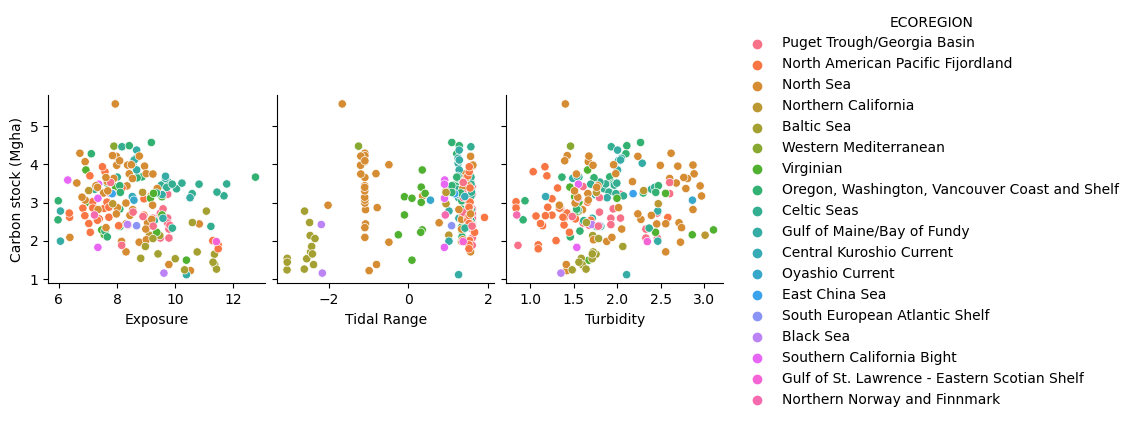

In [108]:
#rename columns
df_log_all = df_log_all.rename(columns={'exposure': 'Exposure', 'Tidal_range': 'Tidal Range', 'mean_area_TUR_Nechad2016_665':'Turbidity', 'Carbon stock Mgha':'Carbon stock (Mgha)'})
pp = sns.pairplot(data=df_log_all,
                  y_vars=['Carbon stock (Mgha)'],
                  x_vars=['Exposure', 'Tidal Range', 'Turbidity'],
                 hue = 'ECOREGION')
pp;

pp.savefig("small_pairplot.png") 

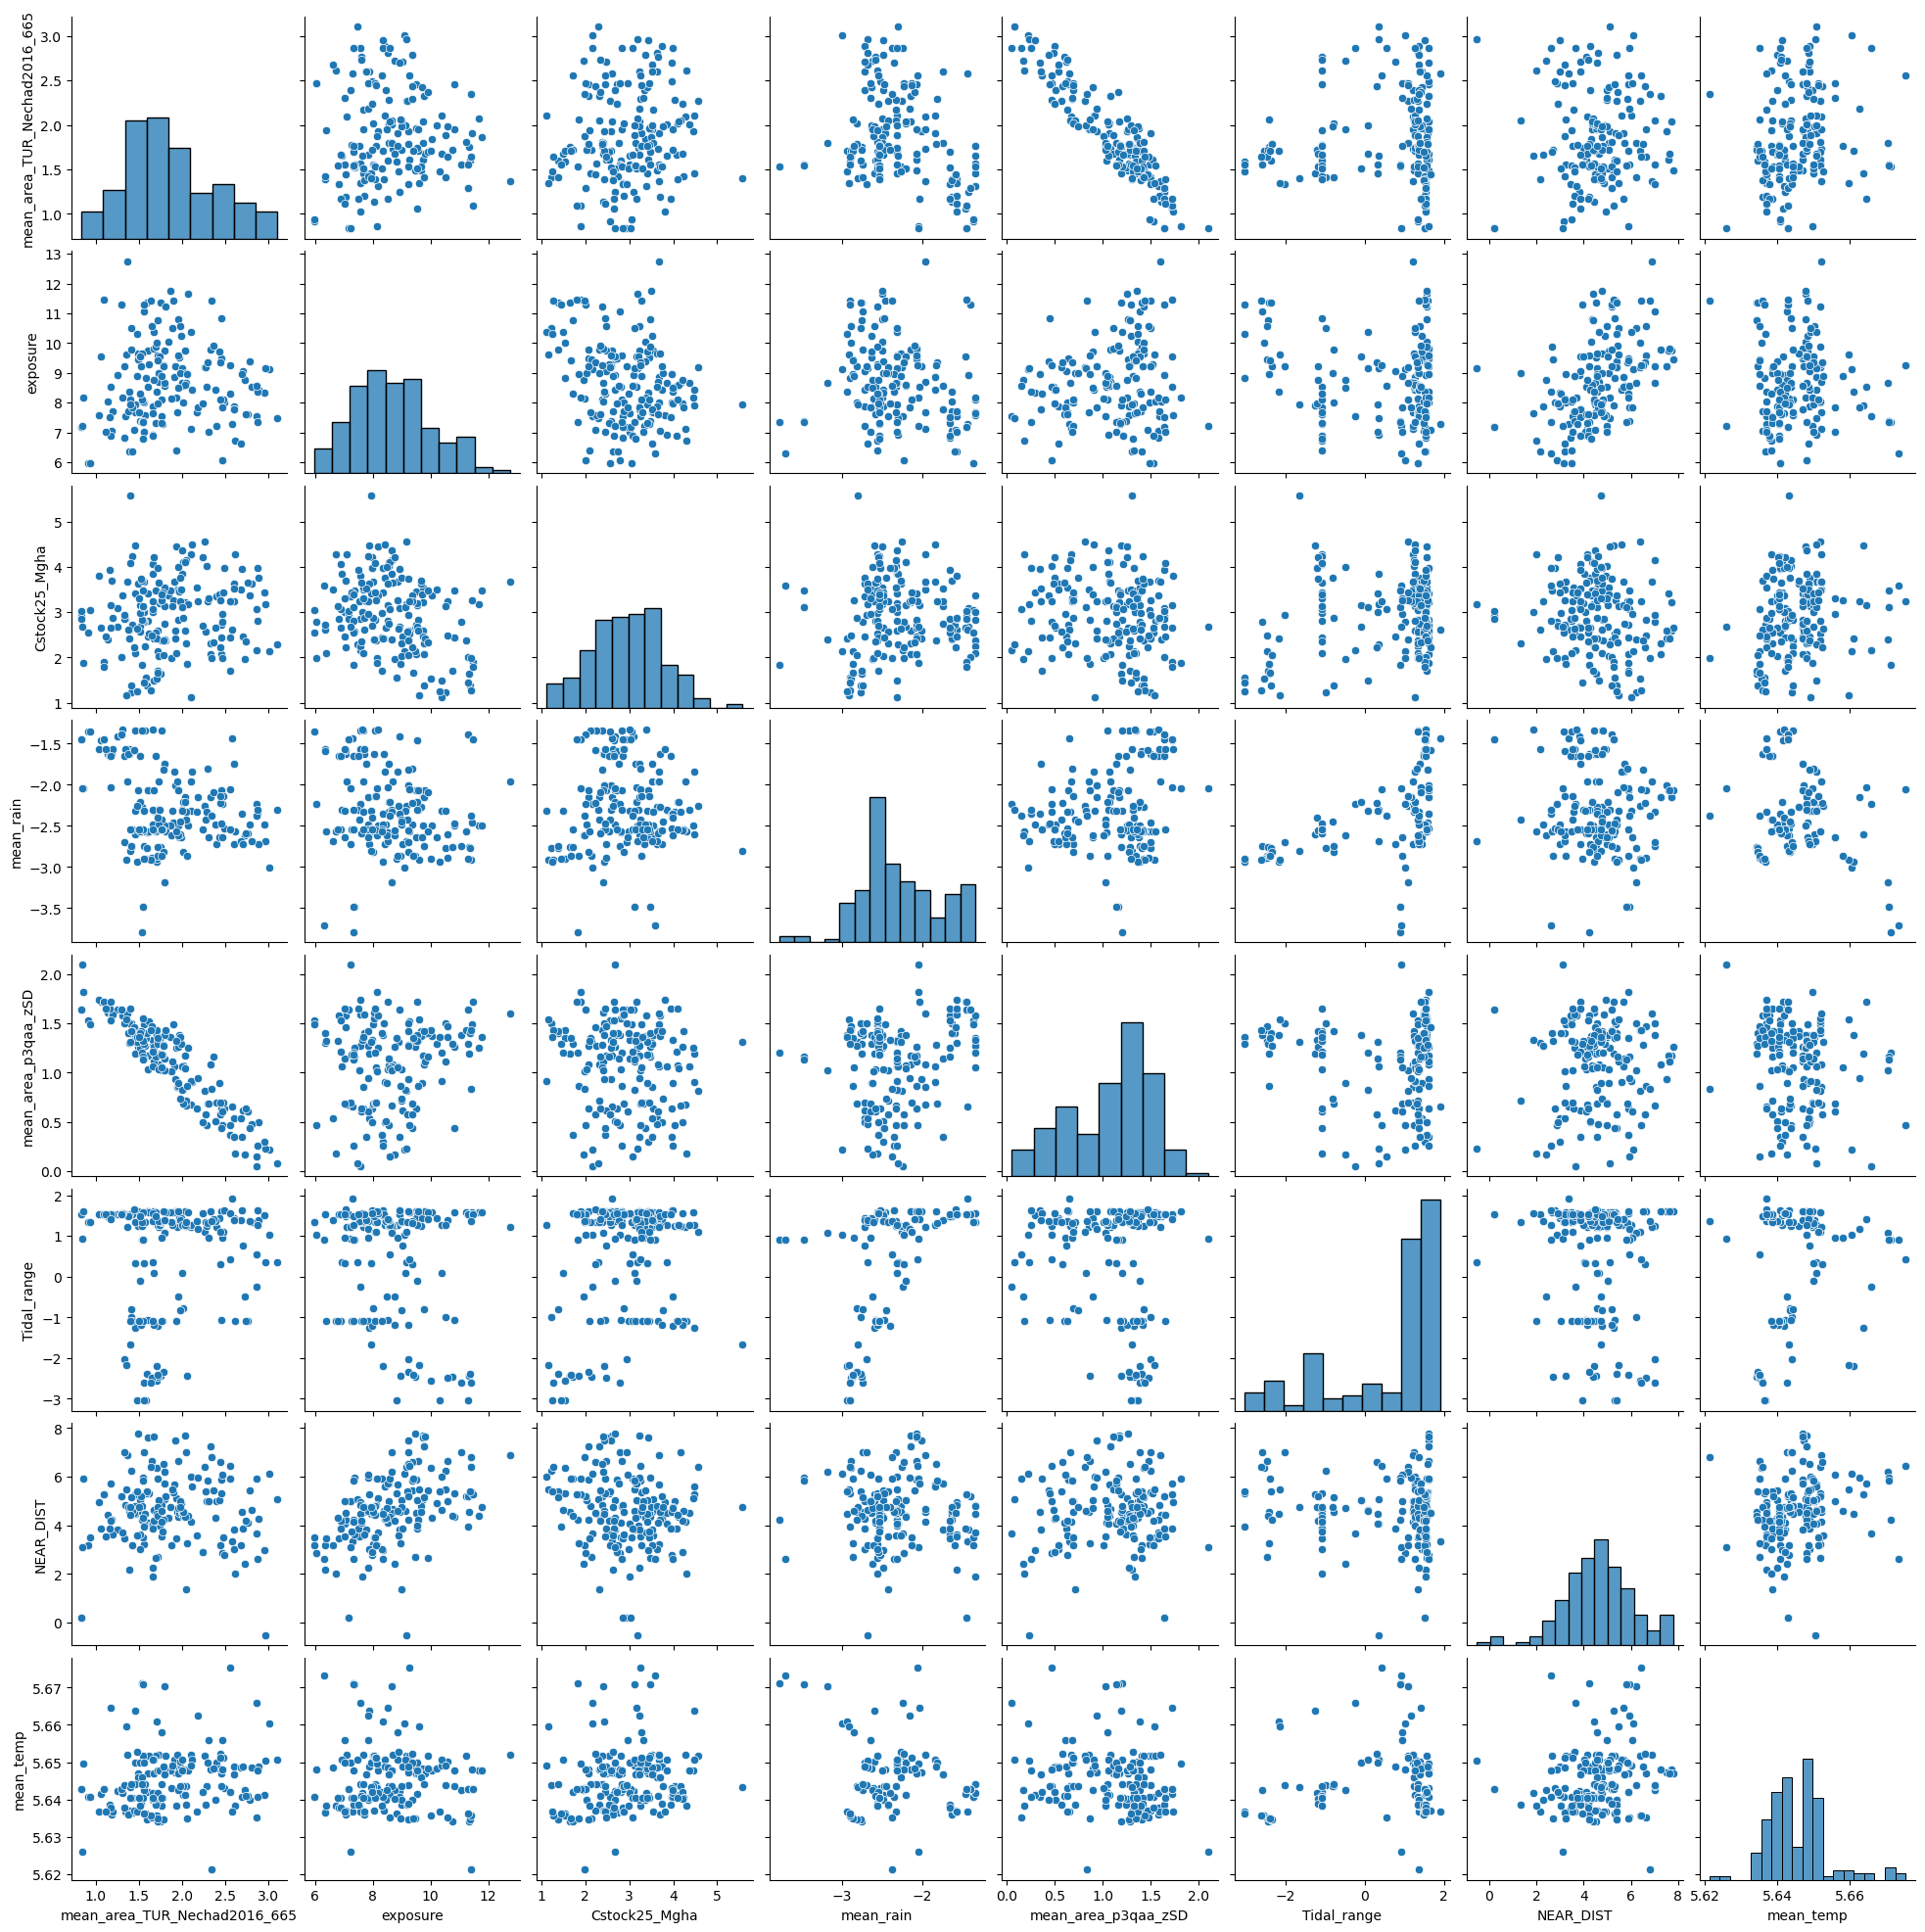

In [99]:
sns.pairplot(df_log_all)

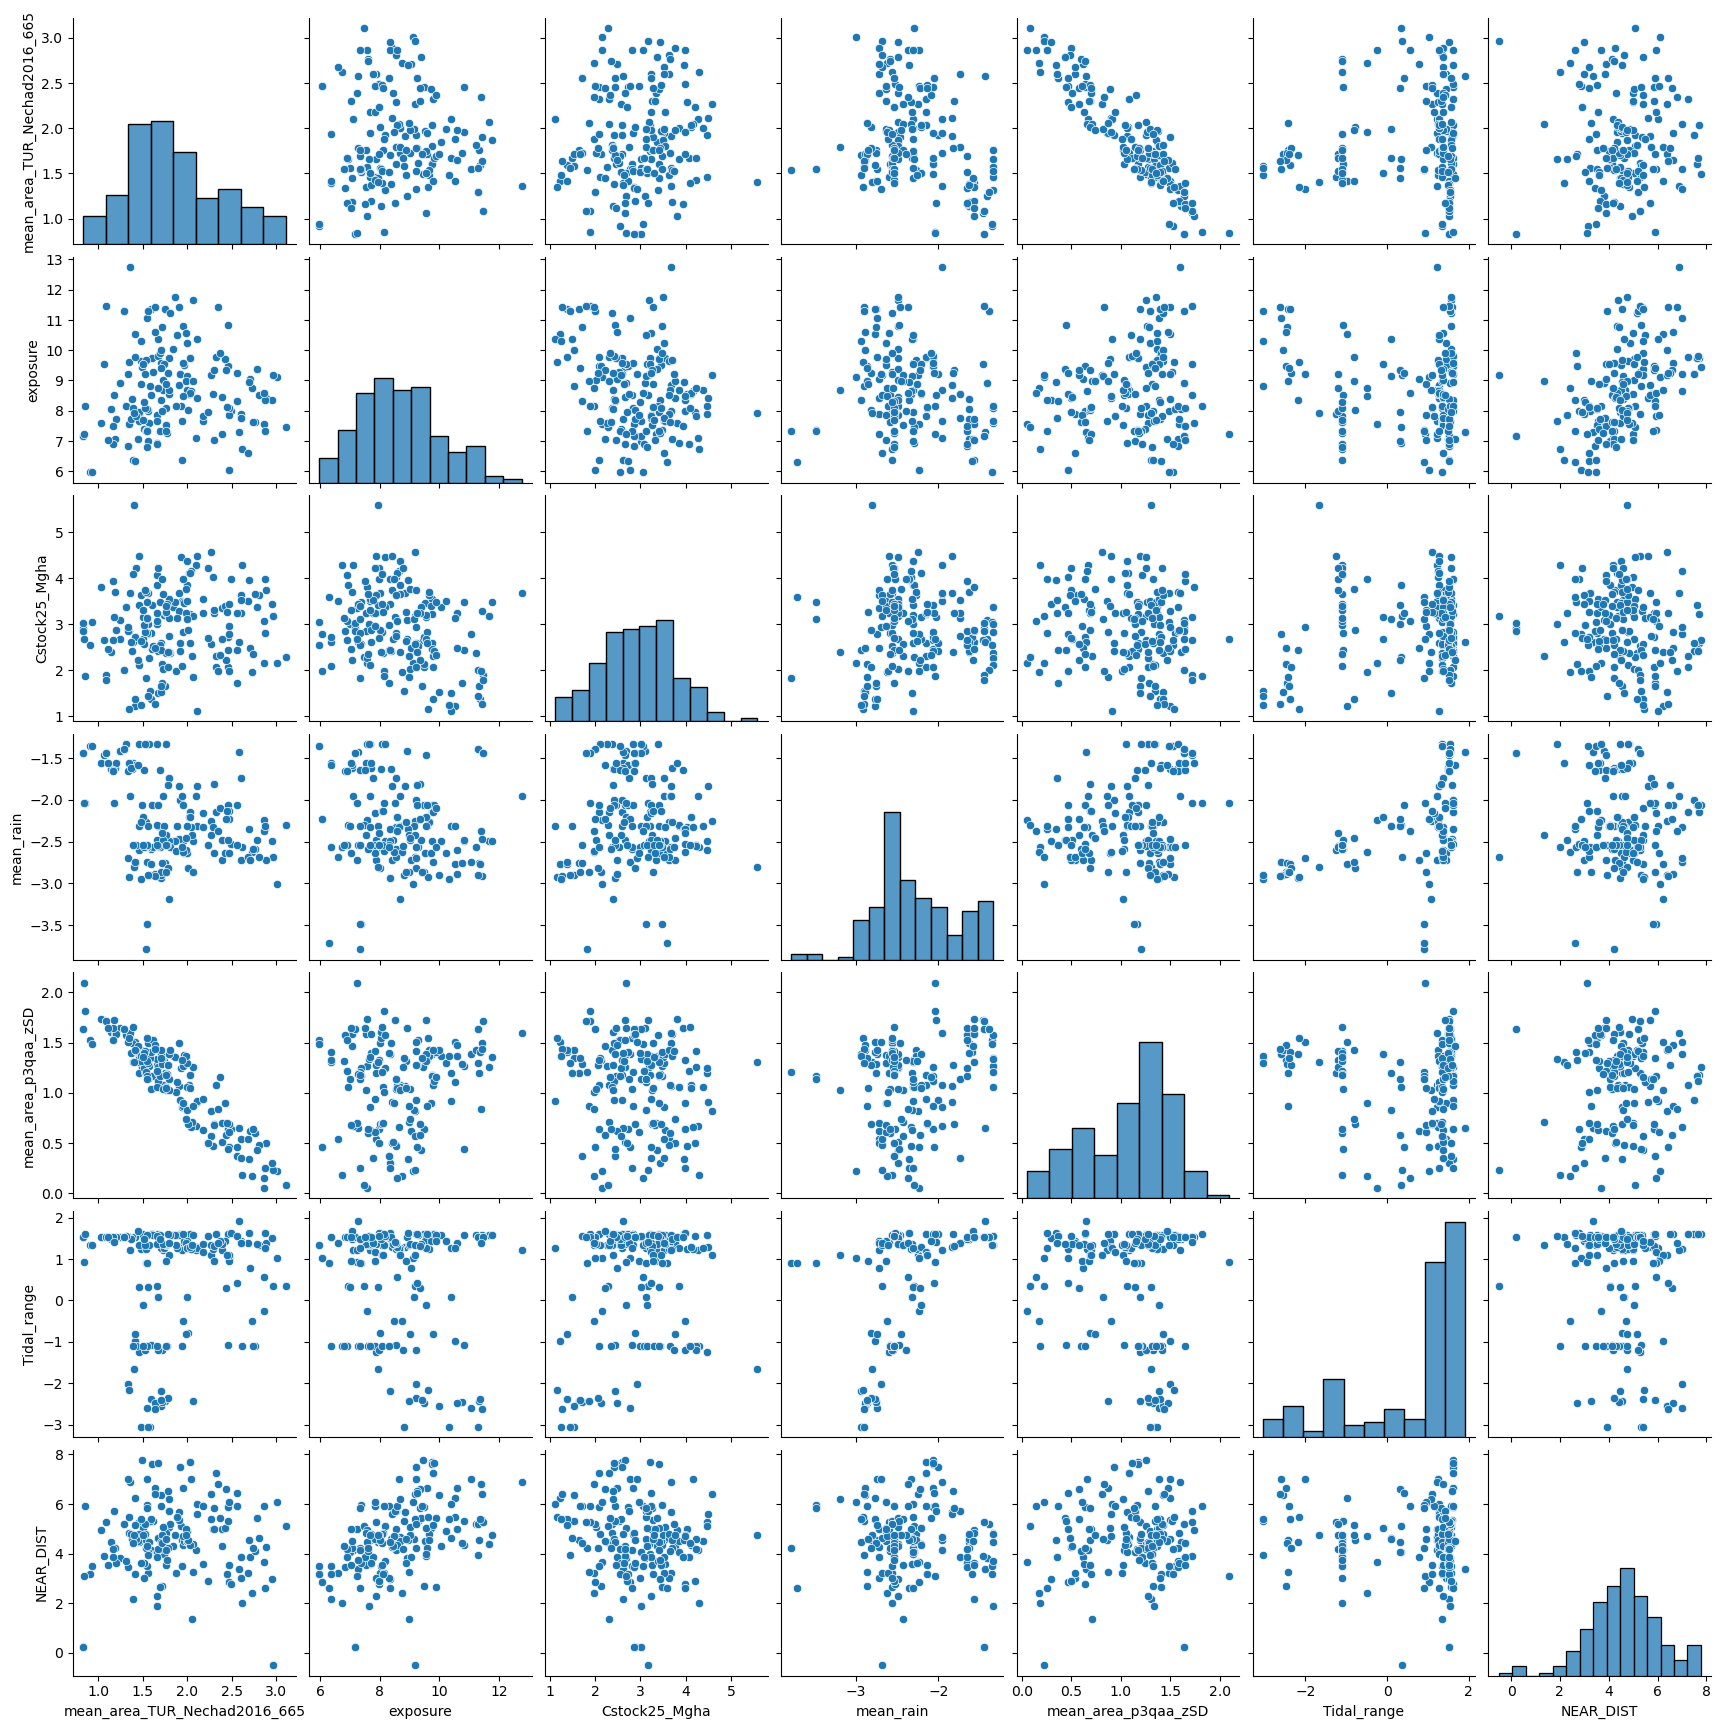

In [227]:
log_df = np.log(df_x)
sns.pairplot(log_df)

zSD (secchi depth) and TUR (turbidity) are correlated as expected as clarity of water will decrease with increasing turbidity. But no real correlation of carbon stock with the predictor variables


<AxesSubplot:>

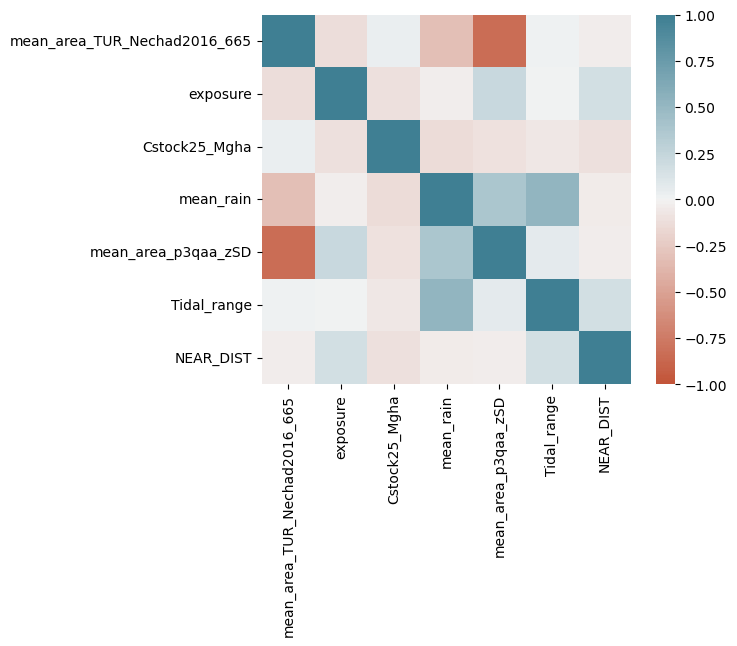

In [29]:
sns.heatmap(
    df_x.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

## Run Boosted Regression Tree

In [212]:
#create the empty model
reg = GradientBoostingRegressor(n_estimators  = 100, 
                                max_depth = 3, 
                                learning_rate = 0.1, 
                                min_samples_split = 3)

In [213]:
#fit the model
reg.fit(X_train, y_train)

GradientBoostingRegressor(min_samples_split=3)

In [214]:
# predict the test-set 
y_pred = reg.predict(X_test)

In [215]:
from sklearn.metrics import mean_squared_error as MSE

In [216]:
#compute test-set labels
mse = MSE(y_test, y_pred)
rmse = mse**(1/2)
print('The RMSE (root of the squared mean error is', rmse)

The RMSE (root of the squared mean error is 28.298359297006407


THe RMSE measures on average how much the models predictions differ from the actual labels

In [217]:
print('accuracy on training set: {:.3f}'.format(reg.score(X_train, y_train)))
print('accuracy on test set: {:.3f}'.format(reg.score(X_test, y_test)))

accuracy on training set: 0.966
accuracy on test set: -0.782


Tuning the parameters (max_depth up to 5 max, n_estimateors, learning rate) to have a high accuracy on training set with a high accuracy on test set - current looks like overfitting on training set and poor fit on test set. 

In [50]:
## Increase max depth
reg3 = GradientBoostingRegressor(n_estimators  = 100, #number of trees
                                max_depth = 3,  #max leaf nodes
                                learning_rate = 0.1,  #the degree to which each tree is allowed to correct the mistakes of the previous trees
                                min_samples_split = 3)
#learning rate and n_estimators are interconnected
#lower learning rate means more trees are needed to build a model of similar complexity

#fit the model
reg3.fit(X_train, y_train)
# predict the test-set 
y_pred3 = reg3.predict(X_test)
#compute test-set labels
mse = MSE(y_test, y_pred3)
rmse = mse**(1/2)
print('The RMSE (root of the squared mean error is', rmse)

The RMSE (root of the squared mean error is 31.653464400816226


#### Tuning other parameters for comparison

In [45]:
## Increase max depth
reg8 = GradientBoostingRegressor(n_estimators  = 100, 
                                max_depth = 3, 
                                learning_rate = 0.1, 
                                min_samples_split = 3)
#fit the model
reg8.fit(X_train, y_train)
# predict the test-set 
y_pred8 = reg8.predict(X_test)
#compute test-set labels
mse = MSE(y_test, y_pred8)
rmse = mse**(1/2)
print('The RMSE (root of the squared mean error is', rmse)

The RMSE (root of the squared mean error is 44.24339561842854


In [34]:
#r2 score for the model (on the test data)
reg.score(X_test, y_test)

-4.854143609025305

In [46]:
reg3.score(X_train, y_train)

0.9663138285095494

### Determine the features importance

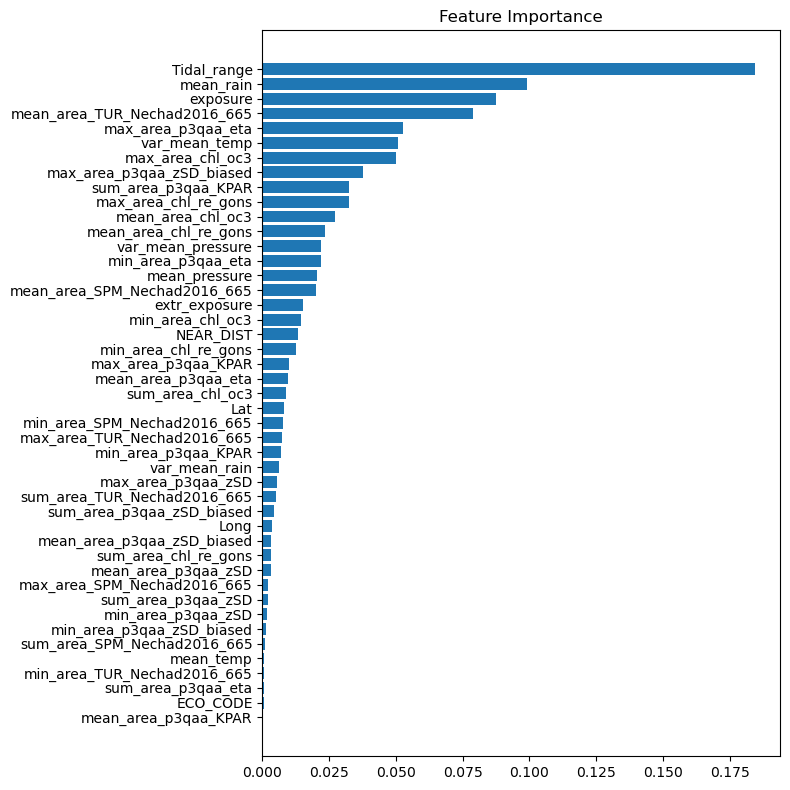

In [183]:
from sklearn.inspection import permutation_importance
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])+ .5

fig = plt.figure(figsize = (8,8))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
result = permutation_importance(reg, X_test, y_test, n_repeats = 100, random_state = 42, n_jobs = 2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

## Neural Networks

In [223]:
from sklearn.neural_network import MLPClassifier

In [225]:
mlp = MLPClassifier(random_state = 0).fit(X_train, y_train)
mglearn.plots.plot_2d_seperator(mlp, X_train, fill = True, alpha = .3)
mglearn.discrete_scatter(X_train[:,0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylable("Feature 1")

ValueError: Unknown label type: (array([ 87.93,  10.86,   7.96,  40.46,  11.5 ,  22.51,  29.94,  24.74,
        29.01,  47.14,  27.28,   9.84,  15.67,  14.27,  67.37,  13.71,
        11.63,  22.92, 265.23,  28.83,  10.74,  11.93,  18.76,  42.42,
         8.09,  20.35,   9.55,  13.62,  16.94,  13.34,   7.28,   8.57,
        25.36,  21.48,  42.61,  13.71,  42.81,  11.29,  31.25,  32.73,
         9.25,  25.81,   3.05,   7.25,  17.61,  13.39,  16.7 ,  15.28,
        72.07,  61.21,  16.08,  37.76,  32.53,  37.88,   4.46,  26.43,
         9.24,  16.7 ,  29.95,  31.21,   7.4 ,  17.05,   8.49,  12.8 ,
        33.44,  17.43,  38.76,   6.65,  54.08,  39.13,  51.25,  17.27,
        15.29,  21.06,  14.95,  19.85,  12.95,  17.38,  26.25,  29.44,
        53.21,  32.5 ,   3.97,  22.5 ,  25.45,  11.12,  25.84,  11.85,
         7.33,   8.66,  23.52,  31.11,  34.75,   3.18,  11.19,   5.53,
        14.39,  23.97,  56.31,  39.34,   5.21,  73.09,  25.  ,  14.47,
        16.74,  52.13,  14.53,  12.67,  10.98,   5.25,  60.66,  14.35,
        19.49,  10.44,  34.37,  58.55,  25.38,  20.22,  96.83,   6.57,
         5.54,   4.23,  12.52,  88.96,  17.81,  10.98,   3.46,   8.2 ,
        67.82,  23.89,  31.75,   6.38,  10.31,  18.34,  14.55,   7.43,
        25.39,  16.11,  33.44,  10.06,   7.96,  34.  ,  60.  ,   7.84,
        32.55,  40.02,  13.36,   7.6 ,   3.98]),)

### Run multiple linear regression with scikit-learn

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [185]:
#create a regression model
model = LinearRegression()

In [186]:
#fitting the model
model.fit(X, y)

LinearRegression()

In [187]:
#making predictions
predictions = model.predict(X_test)

In [188]:
#model evaluation
print('mean_squared_error: ', mean_squared_error(y_test, predictions))
print('mean_absolute_error: ', mean_absolute_error(y_test, predictions))

mean_squared_error:  231.4185080146154
mean_absolute_error:  11.347979819758852


mean squared error is the average squared error of the regressions

In [189]:
print(model.intercept_)

-3763.6316543123


In [190]:
print(model.coef_)

[-5.17481895e-01  3.44370883e-01 -6.60653269e-05  5.19236318e-03
 -3.71515444e-06 -3.88697321e-03  3.57265292e-01 -5.75488634e-04
  1.12511866e+04 -1.20439567e+04 -8.72672018e+01  9.68249413e+01
 -8.70489130e+00 -3.10044951e+00 -6.32809640e+01  4.03319516e+00
  3.26418743e+08 -3.49356773e+08  2.30799156e+03 -2.41148524e+03
 -3.79414301e+02 -9.24024608e+01 -1.21080992e+01  2.42602778e-01
 -3.76228135e+07  4.02666353e+07 -3.86553038e+02  4.05188949e+02
  7.41249988e+01  7.11504379e+01  4.92461246e+00 -3.35608881e-01
 -2.70029955e+07  2.89005447e+07 -1.42385836e+02  1.47317056e+02
  2.12708005e+01  3.01377752e+00  5.01793071e-02 -1.01798808e-04
 -4.31031385e+00 -4.39146258e-01  1.56185261e+02 -2.24152890e+03
 -2.78097050e+00]


In [191]:
for name, coef in zip(X, model.coef_):
    print(f'{name}: {coef}')

Lat: -0.5174818947385178
Long: 0.34437088317424686
exposure: -6.606532689515524e-05
ECO_CODE: 0.00519236317925565
extr_exposure: -3.715154441528636e-06
NEAR_DIST: -0.003886973214097777
max_area_chl_oc3: 0.3572652920776494
max_area_chl_re_gons: -0.0005754886343721367
max_area_TUR_Nechad2016_665: 11251.186576378814
max_area_SPM_Nechad2016_665: -12043.956678543747
max_area_p3qaa_zSD: -87.26720178810089
max_area_p3qaa_zSD_biased: 96.82494131025747
max_area_p3qaa_eta: -8.704891301315179
max_area_p3qaa_KPAR: -3.100449507564486
mean_area_chl_oc3: -63.280963989753566
mean_area_chl_re_gons: 4.033195155258054
mean_area_TUR_Nechad2016_665: 326418742.67718536
mean_area_SPM_Nechad2016_665: -349356773.37139344
mean_area_p3qaa_zSD: 2307.9915635471198
mean_area_p3qaa_zSD_biased: -2411.485240179189
mean_area_p3qaa_eta: -379.4143009836548
mean_area_p3qaa_KPAR: -92.40246081153462
min_area_chl_oc3: -12.108099180924413
min_area_chl_re_gons: 0.24260277757017587
min_area_TUR_Nechad2016_665: -37622813.4531963

In [196]:
from sklearn.metrics import r2_score
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 15
r2: 0.3345


In [198]:
#use statsmodels to get a more detailed analysis 
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = sm.OLS(y_test, X_test.assign(const=1))
results = model.fit()
results.summary()

C:\Users\nw431\Miniconda3\envs\py101\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\nw431\Miniconda3\envs\py101\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\nw431\Miniconda3\envs\py101\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cstock25_Mgha   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                nan
Time:                        14:08:47   Log-Likelihood:                 677.10
No. Observations:                  38   AIC:                            -1278.
Df Residuals:                       0   BIC:                            -1216.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Lat                             -3.9112        inf         -0        nan         nan         nan
Long                            -1.1282        inf         -0        nan         nan         nan
exposure                         0.0010        inf          0        nan         nan         nan
ECO_CODE                         0.0214        inf          0        nan         nan         nan
extr_exposure                   -0.0008        inf         -0        nan         nan         nan
NEAR_DIST                       -0.0090        inf         -0        nan         nan         nan
max_area_chl_oc3                11.6934        inf          0        nan         nan         nan
max_area_chl_re_gons            -0.7688        inf         -0        nan         nan         nan
max_area_TUR_Nechad2016_665     -2.3491        inf         -0        nan         nan         nan
max_area_SPM_Nechad2016_665     -1.9871        inf         -0        nan         nan         nan
max_area_p3qaa_zSD             153.2834        inf          0        nan         nan         nan
max_area_p3qaa_zSD_biased     -165.6889        inf         -0        nan         nan         nan
max_area_p3qaa_eta              53.5887        inf          0        nan         nan         nan
max_area_p3qaa_KPAR             -6.9589        inf         -0        nan         nan         nan
mean_area_chl_oc3             -829.8296        inf         -0        nan         nan         nan
mean_area_chl_re_gons           16.6875        inf          0        nan         nan         nan
mean_area_TUR_Nechad2016_665   -21.7035        inf         -0        nan         nan         nan
mean_area_SPM_Nechad2016_665   -20.1202        inf         -0        nan         nan         nan
mean_area_p3qaa_zSD           -341.2853        inf         -0        nan         nan         nan
mean_area_p3qaa_zSD_biased     252.2844        inf          0        nan         nan         nan
mean_area_p3qaa_eta           1297.1678        inf          0        nan         nan         nan
mean_area_p3qaa_KPAR          1387.8031        inf          0        nan         nan         nan
min_area_chl_oc3               125.8469        inf          0        nan         nan         nan
min_area_chl_re_gons            -5.8874        inf         -0        nan         nan         nan
min_area_TUR_Nechad2016_665     11.7326        inf          0        nan         nan         nan
min_area_SPM_Nechad2016_665     11.5133        inf          0        nan         nan         nan
min_area_p3qaa_zSD           -4826.4140        inf         -0        nan         nan         nan
min_area_p3qaa_zSD_biased     5097.8824        inf          0        nan         nan         nan
min_area_p3qaa_eta            -218.3737        inf         -0        nan    

Standard error of the coefficients can be used to measure the reliability of a variables contribution to a model

#### Stepwise regression to determine which variables should be included in the model....

## Run Random Forest

In [234]:
#import Random Forest model
from sklearn.ensemble import RandomForestRegressor

In [235]:
#Create a Gaussian Classifier
regr = RandomForestRegressor(n_estimators = 100, max_depth = 3, random_state =0)
#Train the model using the training sets
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [236]:
#error score
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred)) 
#lower error the better :-(

MAE:  15.800402637777959
MSE:  427.5638681377981


In [237]:
#Import scikit_learn metrics module for accuracy calculation
from sklearn import metrics
#Model accuracy, how often is the regressor correct?


### Model selection: Forward Stepwise Regression

Starting with no covariates, add variables one at a time, trying to minimise the score.
For no particular reason, I am choosing to minimise Bayesian Information. BIC tends to choose models with fewer parameters than AIC.

In [239]:
import numpy as np #for inf

variables = list(X.columns)
min_bic = np.inf;
min_variables = None
forward_variables = []

while len(variables): #while there is something to add
    added = None;     #the variable added this turn (or None)
    for v in variables:
        model = sm.OLS(y, X[ forward_variables + [v] ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = forward_variables + [v]
            min_bic = model.bic
            added = v;

    if len(min_variables) == len(forward_variables): break; #no change in best
    forward_variables = min_variables; #start from best so far for next iteration
    variables.remove(added)            #don't check stuff we've already added!
    
    
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.500
Model:                            OLS   Adj. R-squared (uncentered):              0.497
Method:                 Least Squares   F-statistic:                              186.1
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                    8.12e-30
Time:                        16:24:45   Log-Likelihood:                         -874.21
No. Observations:                 187   AIC:                                      1750.
Df Residuals:                     186   BIC:                                      1754.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mean_temp      0.0917      0.007     13.641      0.000       0.078       0.105
==============================================================================
Omnibus:                      223.533   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11408.515
Skew:                           4.706   Prob(JB):                         0.00
Kurtosis:                      40.089   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [242]:
min_variables

['Long', 'ECO_CODE']

### Model selection: Backwards Stepwise Regression

Starting with all the covariates, remove variables one at a time, trying to minimise the score.

In [241]:
variables = list(X.columns)

backward_variables = variables

model = sm.OLS(y, X[ backward_variables ]).fit()
min_bic = model.bic;
min_variables = backward_variables

while len(variables): #while there is something to add
    print(backward_variables)
    removed = None;     #the variable added this turn (or None)
    for v in backward_variables:
        mvar = [w for w in backward_variables if w!=v]
        model = sm.OLS(y, X[ mvar ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = mvar
            min_bic = model.bic
            removed = v;

    if len(min_variables) == len(backward_variables): break; #no change in best
    backward_variables = min_variables; #start from best so far for next iteration
    variables.remove(removed)            #don't check stuff we've already added!

model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

['Lat', 'Long', 'exposure', 'ECO_CODE', 'extr_exposure', 'NEAR_DIST', 'max_area_chl_oc3', 'max_area_chl_re_gons', 'max_area_TUR_Nechad2016_665', 'max_area_SPM_Nechad2016_665', 'max_area_p3qaa_zSD', 'max_area_p3qaa_zSD_biased', 'max_area_p3qaa_eta', 'max_area_p3qaa_KPAR', 'mean_area_chl_oc3', 'mean_area_chl_re_gons', 'mean_area_TUR_Nechad2016_665', 'mean_area_SPM_Nechad2016_665', 'mean_area_p3qaa_zSD', 'mean_area_p3qaa_zSD_biased', 'mean_area_p3qaa_eta', 'mean_area_p3qaa_KPAR', 'min_area_chl_oc3', 'min_area_chl_re_gons', 'min_area_TUR_Nechad2016_665', 'min_area_SPM_Nechad2016_665', 'min_area_p3qaa_zSD', 'min_area_p3qaa_zSD_biased', 'min_area_p3qaa_eta', 'min_area_p3qaa_KPAR', 'sum_area_chl_oc3', 'sum_area_chl_re_gons', 'sum_area_TUR_Nechad2016_665', 'sum_area_SPM_Nechad2016_665', 'sum_area_p3qaa_zSD', 'sum_area_p3qaa_zSD_biased', 'sum_area_p3qaa_eta', 'sum_area_p3qaa_KPAR', 'mean_pressure', 'var_mean_pressure', 'mean_temp', 'var_mean_temp', 'mean_rain', 'var_mean_rain', 'Tidal_range']
[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.509
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                              96.03
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                    2.48e-29
Time:                        16:26:10   Log-Likelihood:                         -872.47
No. Observations:                 187   AIC:                                      1749.
Df Residuals:                     185   BIC:                                      1755.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Long           0.0853      0.031      2.717      0.007       0.023       0.147
ECO_CODE       0.0014      0.000     11.571      0.000       0.001       0.002
==============================================================================
Omnibus:                      222.314   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11346.964
Skew:                           4.660   Prob(JB):                         0.00
Kurtosis:                      40.006   Cond. No.                         374.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model selection: Other Optimisers

The forward and backward procedures are greedy optimisers, greedy search is usually not the best. You are trying to minimise some function (Bayesian information) so try some other __[Optimiser](https://docs.scipy.org/doc/scipy/reference/optimize.html)__ . The optimiser has to be a very general one because computing the derivatives to too hard! 

I'm going to do a trick where I represent a list of variables as a binary number of fixed width so e.g.<br>
['RM', 'LSTAT', 'CHAS', 'NOX', 'AGE']<br>
v = 0 1 0 0 1 1<br>
gives ['LSTAT', 'NOX', 'AGE']

Let's try with more variables and a fancy optimisation algorithm called basin hopping...

In [244]:
from scipy.optimize import basinhopping

variables = list(X.columns)

def func(v):
    if sum(v) == 0: return 10e10;
    model = sm.OLS(y, X[ [var for i,var in enumerate(variables) if v[i] > 0.5] ]).fit()
    return model.bic
      
class MyStep:
   def __init__(self, stepsize=0.5):
       self.rng = np.random.default_rng()
       self.M = len(variables) 
   def __call__(self, x):
       idx = self.rng.integers(0,high=self.M)
       x[idx] = 1 - x[idx]
       return x

v0 = np.ones( len(variables), dtype=np.int8 )

minimizer_kwargs = {"method": "BFGS"}
mystep = MyStep()
print("basin_hopping...")
ret = basinhopping(func, v0, minimizer_kwargs=minimizer_kwargs, niter=200, take_step=mystep)

min_variables = [var for i,var in enumerate(variables) if ret.x[i] > 0.5]
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

basin_hopping...


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.526
Model:                            OLS   Adj. R-squared (uncentered):              0.515
Method:                 Least Squares   F-statistic:                              50.69
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                    1.14e-28
Time:                        16:29:36   Log-Likelihood:                         -869.32
No. Observations:                 187   AIC:                                      1747.
Df Residuals:                     183   BIC:                                      1760.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
mean_area_SPM_Nechad2016_665    -0.9123      0.646     -1.412      0.160      -2.188       0.363
mean_area_p3qaa_eta            -93.4221     29.927     -3.122      0.002    -152.468     -34.376
min_area_p3qaa_eta              62.9419     24.216      2.599      0.010      15.163     110.721
mean_pressure                    0.0006      0.000      3.956      0.000       0.000       0.001
==============================================================================
Omnibus:                      226.797   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12605.500
Skew:                           4.784   Prob(JB):                         0.00
Kurtosis:                      42.067   Cond. No.                     1.98e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Zheng-Loh Model Selection

Simple and it's supposed to work. Zheng and Loh showed that, under appropriate conditions, this method
chooses the true model with probability tending to one as the sample size increases.

1. Fit everything and compute the Wald test statistic for H0 : $c_j = 0$ versus H1 : $c_j = 0$ (I think this is more or less just the t score???)
2. Sort

In [245]:
variables = list(X.columns)
model = sm.OLS(y, X[ variables ]).fit()

sigma_2 = model.mse_resid
def zheng_loh_score(v):
    m = sm.OLS(y, X[ v ]).fit()
    #print(m.ssr, len(v)*sigma_2*np.log(m.nobs), len(v), sigma_2, m.nobs)
    return m.ssr + len(v)*m.mse_resid*np.log(m.nobs)

min_zl = np.inf;
min_variables = []
zl_variables = []
for col, t in model.tvalues.abs().sort_values(ascending=False).items(): 
    zl_score = zheng_loh_score(zl_variables + [col])

    if zl_score < min_zl:
        min_zl = zl_score
        min_variables = [v for v in zl_variables] + [col]
        
    zl_variables += [col]

model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.509
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                              96.03
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                    2.48e-29
Time:                        16:30:13   Log-Likelihood:                         -872.47
No. Observations:                 187   AIC:                                      1749.
Df Residuals:                     185   BIC:                                      1755.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Long           0.0853      0.031      2.717      0.007       0.023       0.147
ECO_CODE       0.0014      0.000     11.571      0.000       0.001       0.002
==============================================================================
Omnibus:                      222.314   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11346.964
Skew:                           4.660   Prob(JB):                         0.00
Kurtosis:                      40.006   Cond. No.                         374.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [246]:
min_variables

['Long', 'ECO_CODE']